# Flight Price Prediction
---

In [3]:
!pip install flask-cors

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import pickle
import flask
import flask_cors

# Data libraries
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

# Visualization libraries
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)

# Sklearn and model building
print("scikit-learn:", sklearn.__version__)

# Web framework
print("flask:", flask.__version__)
print("flask_cors:", flask_cors.__version__)

# Pickle is part of Python standard library, so no version
print("pickle: standard library (no version)")


numpy: 1.26.4
pandas: 2.1.4
matplotlib: 3.8.0
seaborn: 0.12.2
scikit-learn: 1.2.2
flask: 2.2.5
flask_cors: 6.0.1
pickle: standard library (no version)


In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Importing dataset

1. Since data is in form of excel file we have to use pandas read_excel to load the data
2. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
3. Check whether any null values are there or not. if it is present then following can be done,
    1. Imputing data using Imputation method in sklearn
    2. Filling NaN values with mean, median and mode using fillna() method
4. Describe data --> which can give statistical analysis

In [177]:
train_data = pd.read_excel(r"Data_Train.xlsx") 

## By sheet name (If more than 1 sheets are present)
## df = pd.read_excel("path_to_file.xlsx", sheet_name='Sheet2')

In [179]:
pd.set_option('display.max_columns', None)

It tells pandas:

“When displaying a DataFrame, don’t hide any columns — show all of them!”

By default, pandas hides columns if there are too many to fit the screen. This command removes that limit.

In [182]:
train_data.head()
#It displays the first 5 rows of your DataFrame (train_data) by default.

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [184]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


Object is Basically String datatype.
Price is the dependent factor here.


So the Duration column has values which the model cannot understand and train upon (like 2h 50 min etc).
So we have to give some other values to duration.
First we will do some Analysis.

In [129]:
train_data.shape

(10683, 11)

In [130]:
train_data["Duration"].value_counts()

Duration
2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: count, Length: 368, dtype: int64

In [131]:
train_data.dropna(inplace = True)

In [132]:
train_data.shape

(10682, 11)

Since Shape is same it means that there is no NAN value.

In [142]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [144]:
# import seaborn as sns
# sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')


---

## EDA

From description we can see that Date_of_Journey is a object data type,\
Therefore, we have to convert this datatype into timestamp so as to use this column properly for prediction

For this we require pandas **to_datetime** to convert object data type to datetime dtype.

<span style="color: red;">**.dt.day method will extract only day of that date**</span>\
<span style="color: red;">**.dt.month method will extract only month of that date**</span>

Why Convert it?
Machine learning models can’t learn from raw string dates. But they **can learn from:

The day (e.g., is it end-of-month?)

The month (e.g., peak season vs off-season)

In [186]:
train_data["Journey_day"] = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day

This tells pandas:
“Hey, this column is currently just text. Please convert it into real dates using the format: day/month/year.”
So:
"24/03/2019" becomes 2019-03-24 00:00:00
"01/05/2019" becomes 2019-05-01 00:00:00

From each date, extract just the day number.”
So:
2019-03-24 → 24
2019-05-01 → 1

In [188]:
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [190]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [194]:
# Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.

train_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [196]:
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting hours and minutes explicitly using format
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"], format="%H:%M").dt.hour
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"], format="%H:%M").dt.minute

# Drop the original column
train_data.drop(["Dep_Time"], axis=1, inplace=True)


In [198]:
train_data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [200]:
# Arrival time is when the plane pulls up to the gate.
# Similar to Date_of_Journey we can extract values from Arrival_Time

# Extracting Hours
train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour

# Extracting Minutes
train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

C:\Users\BIT\AppData\Local\Temp\ipykernel_22784\1117634591.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour
C:\Users\BIT\AppData\Local\Temp\ipykernel_22784\1117634591.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute


In [202]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [204]:
"2h 50m".split()

['2h', '50m']

In [208]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time


# Assigning and converting Duration column into list
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

After this loop:
Original	Cleaned
"2h 50m"	"2h 50m"
"5h"	"5h 0m"
"30m"	"0h 30m"

In [210]:
len(["5h", "", "0m"]) #That's why .strip() is used

3

In [212]:
# Adding duration_hours and duration_mins list to train_data dataframe

train_data["Duration_hours"] = duration_hours
train_data["Duration_mins"] = duration_mins

In [214]:
train_data.drop(["Duration"], axis = 1, inplace = True)

In [216]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


---

## Handling Categorical Data

One can find many ways to handle categorical data. Some of them categorical data are,
1. <span style="color: blue;">**Nominal data**</span> --> data are not in any order --> <span style="color: green;">**OneHotEncoder**</span> is used in this case
2. <span style="color: blue;">**Ordinal data**</span> --> data are in order --> <span style="color: green;">**LabelEncoder**</span> is used in this case

In [218]:
train_data["Airline"].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

In [222]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

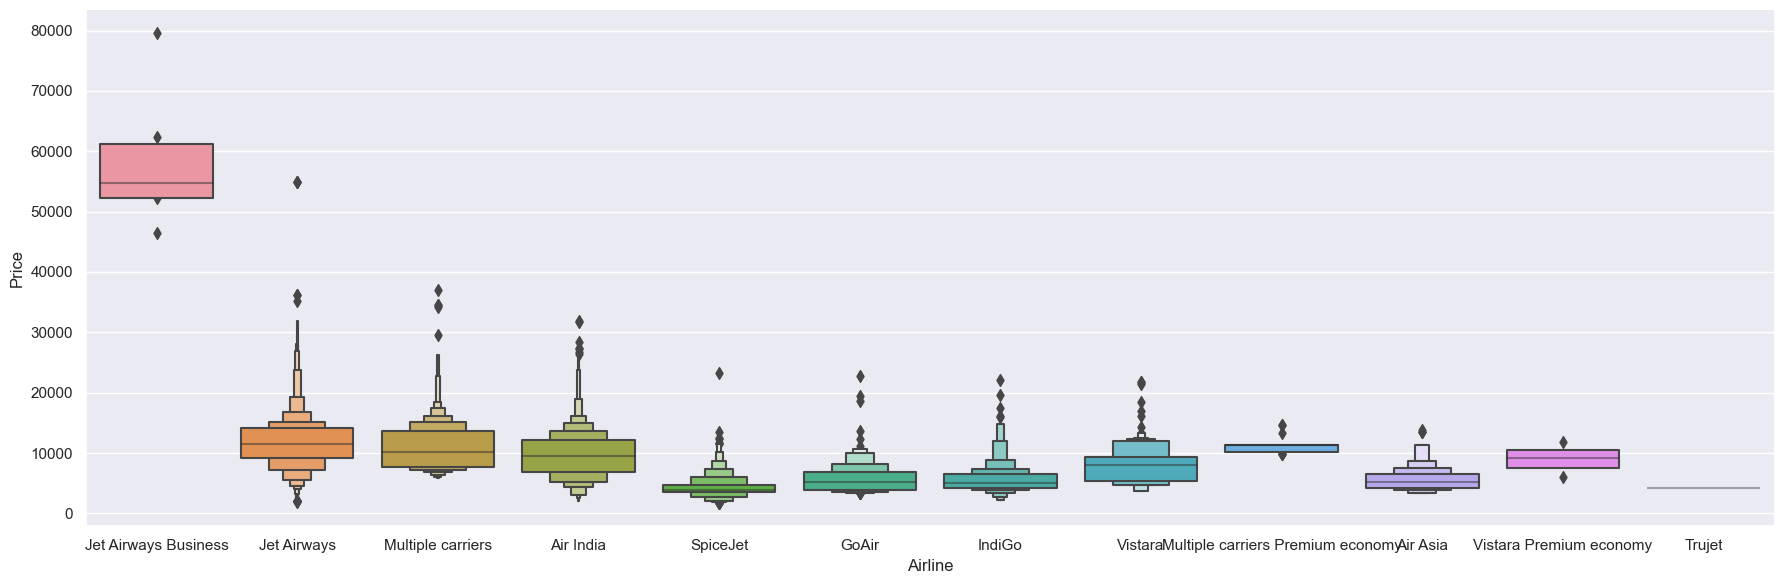

In [226]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

Jet Airways Business price is behaving as an outlier.

In [231]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = train_data[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True).astype(int)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [233]:
train_data["Source"].value_counts()

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

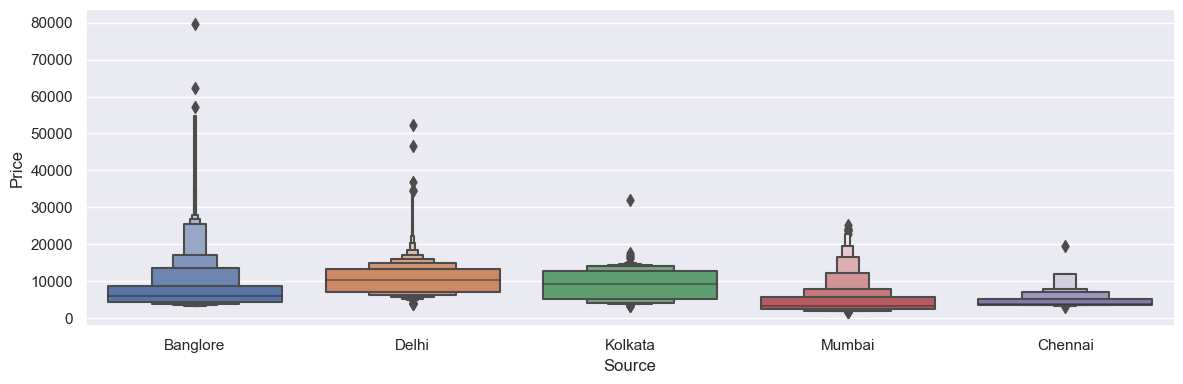

In [235]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [243]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = train_data[["Source"]]

Source = pd.get_dummies(Source, drop_first= True).astype(int)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [237]:
train_data["Destination"].value_counts()

Destination
Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [247]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = train_data[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True).astype(int)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [249]:
train_data["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10683, dtype: object

In [251]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other

train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [253]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1 stop,13302,1,3,16,50,21,35,4,45


In [31]:
train_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [255]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [257]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,0.0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2.0,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1.0,13302,1,3,16,50,21,35,4,45


In [259]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [261]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0.0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2.0,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1.0,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [263]:
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [265]:
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2.0,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2.0,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1.0,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [38]:
data_train.shape

(10682, 30)

---

## Test set

We have not combined the Test and Train Data for pre-processing to avoid data leakage.
The Price Column (dependent feature) will not be present in test data set.


In [276]:
test_data = pd.read_excel(r"Test_set.xlsx")

In [278]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [280]:
# Preprocessing
# Just the same thing which we have done in train_data set.
print("Test data Info")
print("-"*75)
print(test_data.info())

print()
print()

print("Null values :")
print("-"*75)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True).astype(int)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True).astype(int)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True).astype(int)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", data_test.shape)



Test data Info
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


Null values :
---------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time         

C:\Users\BIT\AppData\Local\Temp\ipykernel_22784\568421124.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
C:\Users\BIT\AppData\Local\Temp\ipykernel_22784\568421124.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
C:\Users\BIT\AppData\Local\Temp\ipykernel_22784\568421124.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
C:\Users\BIT\AppData\Local\Temp



Shape of test data :  (2671, 28)


In [282]:
data_test.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


---

## Feature Selection

Finding out the best feature which will contribute and have good relation with target variable.
Following are some of the feature selection methods,


1. <span style="color: purple;">**heatmap**</span>
2. <span style="color: purple;">**feature_importance_**</span>
3. <span style="color: purple;">**SelectKBest**</span>

In [285]:
data_train.shape

(10683, 30)

In [287]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [289]:
X = data_train.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2.0,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2.0,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1.0,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [291]:
y = data_train.iloc[:, 1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

Let’s say the heatmap shows:

Feature	Correlation with Price
Total_Stops	                   0.7 (Positive)
Duration_hours	               0.5
Dep_hour	                   0.02 (Very low)
Airline_Jet Airways	           0.8 (High)
Then:
You’ll probably keep Total_Stops and Airline_Jet Airways
You might consider dropping Dep_hour (very low impact)

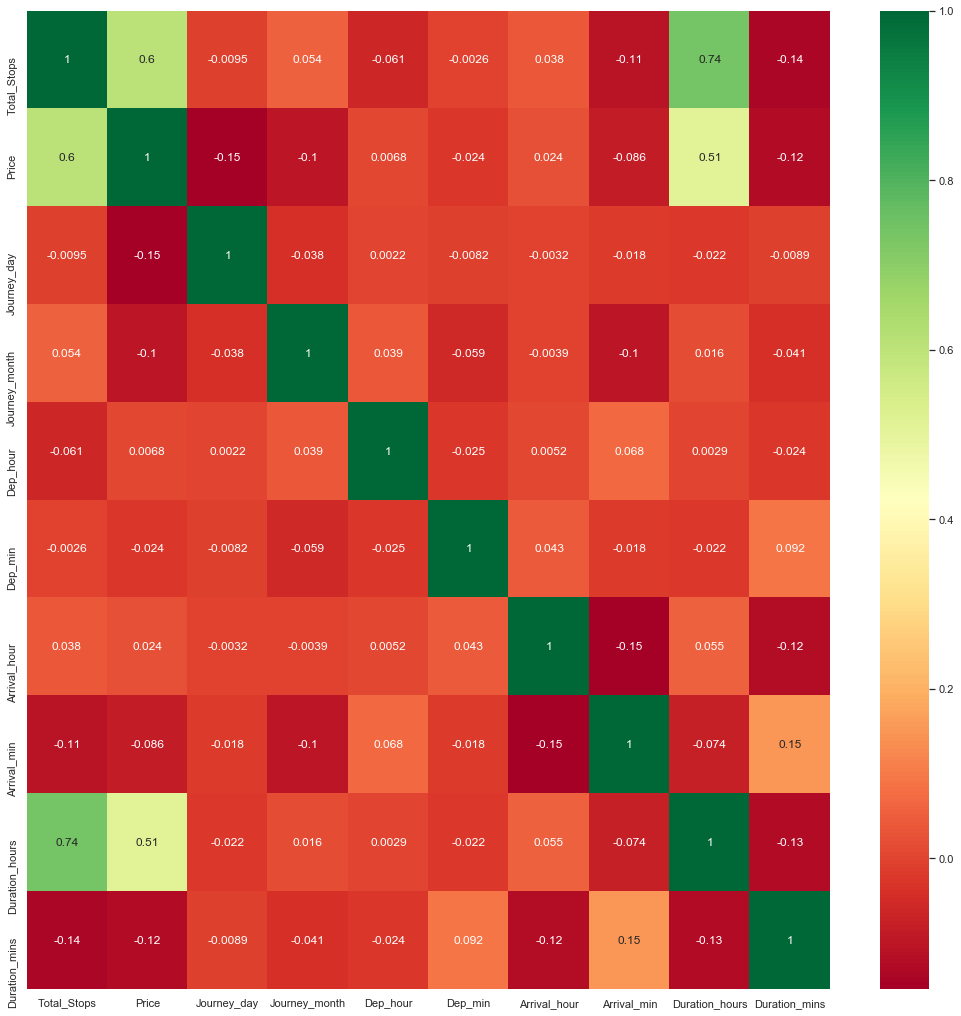

In [47]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(train_data.corr(), annot = True, cmap = "RdYlGn")

plt.show()

Feature	Correlation with Price	Interpretation
Total_Stops	          +0.60	                               Strong positive correlation – more stops, higher price. Important feature ✅
Duration_hours	      +0.51	                               Also strongly positive – longer flights tend to be more expensive. Important ✅
Journey_day	          −0.15	                               Weak negative correlation – day of journey doesn’t affect price much ❌
Journey_month	      −0.10	                               Weak negative correlation – slight seasonal effect ❌
Dep_hour	          +0.0068                              Very weak – no meaningful relationship ❌
Dep_min	              −0.024	                           Also negligible ❌
Arrival_hour	      +0.055	                           Weak – not useful ❌
Arrival_min	          −0.086	                           Weak again ❌
Duration_mins	      −0.12	                               Slight negative effect but not significant ❌

Summary:
Keep These Features	Why?
Total_Stops	Strongest influence on price
Duration_hours	Strong influence on price

Consider Dropping or Revisiting	Why?
Journey_day, Dep_hour, etc.	Very low correlation with price

Now we will use ExtraTreeRegressor to find out which features would be importatnt to predict the output variable
that is price in this case.

In [295]:
# Important feature using ExtraTreesRegressor

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or 'median' / 'most_frequent'
X_imputed = imputer.fit_transform(X)

selection = ExtraTreesRegressor()
selection.fit(X_imputed, y)


ExtraTreesRegressor()

In [297]:
print(selection.feature_importances_)

[2.33968785e-01 1.42592509e-01 5.48618164e-02 2.43369639e-02
 2.14022752e-02 2.75391416e-02 1.90795993e-02 1.02131280e-01
 1.76502584e-02 9.69110826e-03 1.87278759e-03 1.67775406e-02
 1.52006194e-01 6.73454685e-02 1.83424522e-02 8.97445132e-04
 2.94090185e-03 9.31872865e-05 5.19046621e-03 9.49494935e-05
 5.28788898e-04 6.76588192e-03 3.38699391e-03 5.46979787e-03
 1.63928426e-02 1.55656479e-02 7.48683914e-03 4.77814679e-04
 2.51102630e-02]


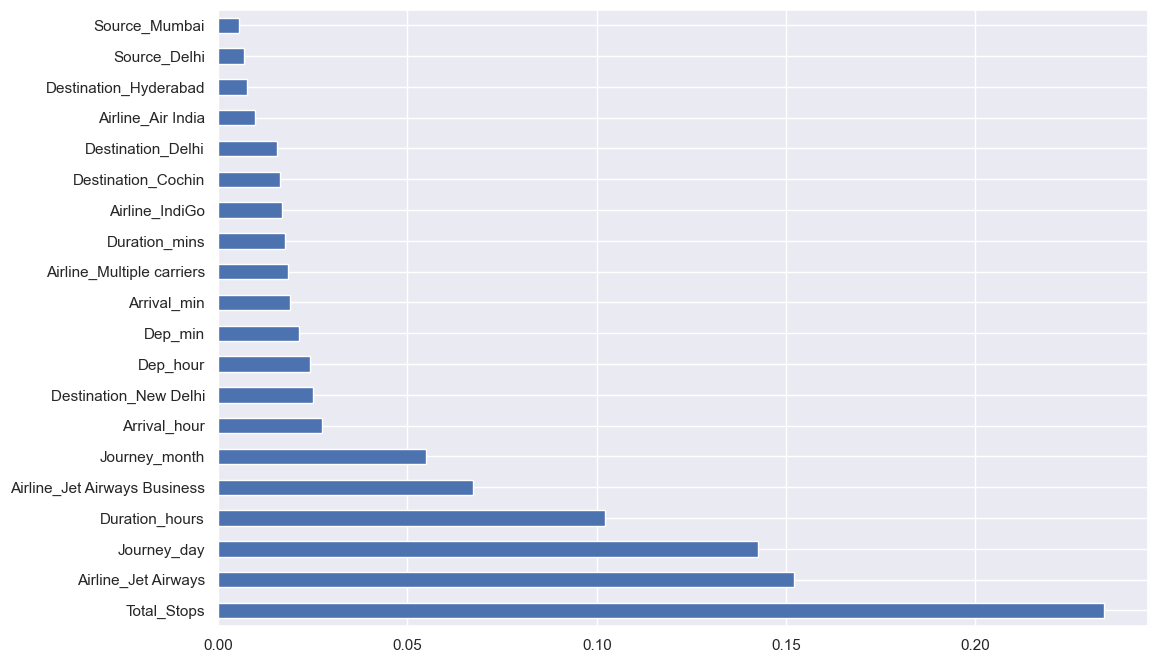

In [299]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


---

## Fitting model using Random Forest

1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data
    * Scaling is not done in Random forest
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check **RSME** Score
7. Plot graph

In [301]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Cleaning Nan values as Random Forest does not work on Nan values

In [305]:
from sklearn.impute import SimpleImputer
# Create an imputer that fills missing values with mean of the column
imputer = SimpleImputer(strategy='mean')
# Fit on training data and transform both train and test
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [307]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [309]:
y_pred = reg_rf.predict(X_test)

In [311]:
reg_rf.score(X_train, y_train)

0.9537845423675394

In [313]:
reg_rf.score(X_test, y_test)

0.7857343831035414

C:\Users\BIT\AppData\Local\Temp\ipykernel_22784\3453123835.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


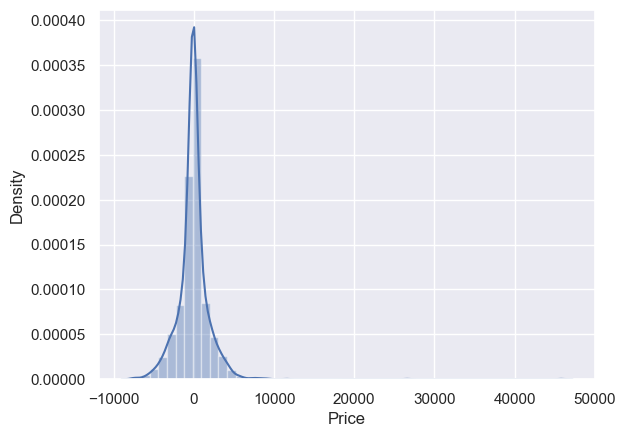

In [315]:
sns.distplot(y_test-y_pred)
plt.show()

It forms a Gaussian Distribution which is a good sign.

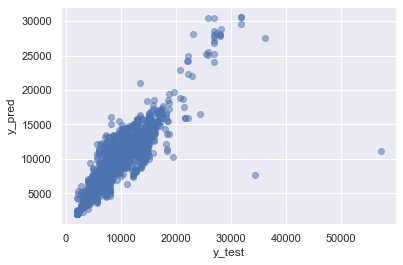

In [57]:

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [317]:
from sklearn import metrics

In [319]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1197.890947908744
MSE: 4534710.242895998
RMSE: 2129.485910471351


In [321]:
# RMSE/(max(DV)-min(DV))

2090.5509/(max(y)-min(y))

0.026887077025966846

In [323]:
metrics.r2_score(y_test, y_pred)

0.7857343831035414

---

## Hyperparameter Tuning


* Choose following method for hyperparameter tuning
    1. **RandomizedSearchCV** --> Fast
    2. **GridSearchCV**
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

In [325]:
from sklearn.model_selection import RandomizedSearchCV

In [327]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [329]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [331]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [333]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   8.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   8.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   6.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   9.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   9.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [335]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [337]:
prediction = rf_random.predict(X_test)

C:\Users\BIT\AppData\Local\Temp\ipykernel_22784\375150797.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


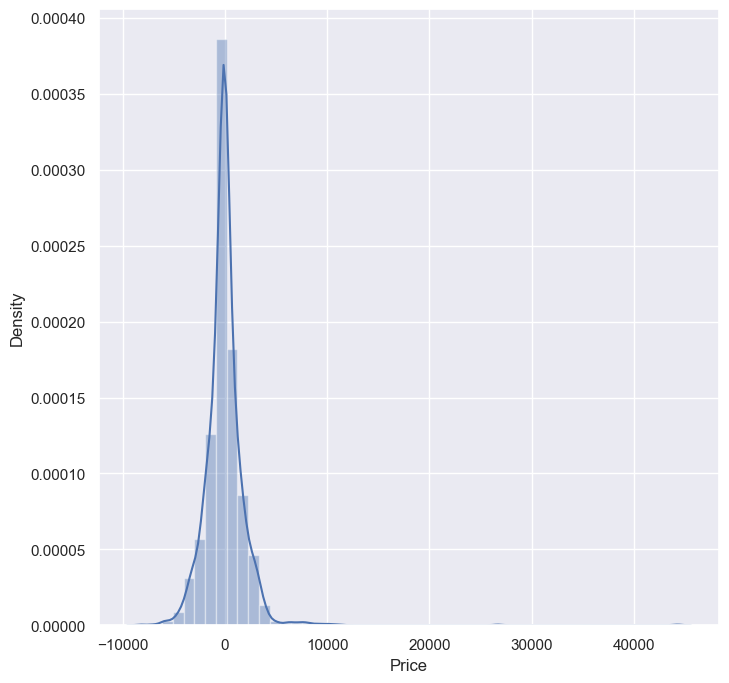

In [339]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

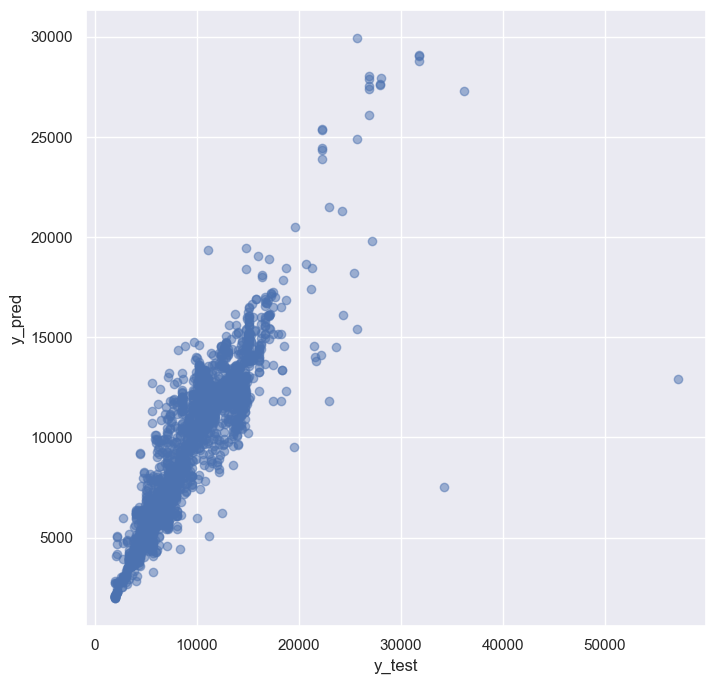

In [341]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [343]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1179.1524850863045
MSE: 4151610.005534534
RMSE: 2037.5500007446526


---

## Save the model to reuse it again

In [355]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [357]:
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)

In [359]:
y_prediction = forest.predict(X_test)

In [361]:
metrics.r2_score(y_test, y_prediction)

0.8038359164528943

In [365]:
packages = [
    "Flask",
    "pandas",
    "scikit-learn",
    "matplotlib",
    "seaborn",
    "numpy"
]

with open("requirements.txt", "w") as f:
    for pkg in packages:
        f.write(pkg + "\n")



---